In [11]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import os
from py2neo import Graph, Node, Relationship
from itertools import permutations
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import uuid  
from typing import Dict, List, Optional, Union, Tuple
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
import itertools
import numpy as np

In [13]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import QAOA
from qiskit_optimization.applications import Tsp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, ADAM
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile


ModuleNotFoundError: No module named 'qiskit'

In [14]:
user = os.getenv("DB_USER")
password = os.getenv("DB_PASS")
apiToken = os.getenv("QISKIT_APITOKEN")
graph_db: Graph = Graph("bolt://localhost:7687", auth=(user, password))

# Queries do banco de dados NEO4J

In [15]:
def shortPathByPOI(
    poiId1: str, 
    poiId2: str
) -> Optional[Dict[str, Union[float, List[str]]]]:

    if not poiId1 or not isinstance(poiId1, str):
        print(f"Invalid poiId1: {poiId1}")
        return None
    if not poiId2 or not isinstance(poiId2, str):
        print(f"Invalid poiId2: {poiId2}")
        return None
    
    query = '''
    MATCH (poi1:POI {osmid: $poiId1})-[:CONNECTED_TO]->(start:Node),
          (poi2:POI {osmid: $poiId2})-[:CONNECTED_TO]->(end:Node)
    CALL apoc.algo.dijkstra(start, end, 'ROAD_TO>', 'length') 
    YIELD path, weight
    RETURN 
        weight AS totalLength,
        [rel IN relationships(path) | id(rel)] AS streetsIds
    '''
    
    try:
        result = graph_db.run(query, poiId1=poiId1, poiId2=poiId2).data()
        
        if not result:
            print(f"No path found between POIs {poiId1} and {poiId2}")
            return None

        data = result[0]
        
        if 'totalLength' not in data or 'streetsIds' not in data:
            print(f"Unexpected result structure: {data}")
            return None
        
        return {
            "totalLength": round(data['totalLength'], 2),  
            "streetsIds": data['streetsIds'],
        }

    except Exception as e:
        print(f"An error occurred while querying the database: {str(e)}")
        return None


In [16]:

def getRoads() -> Optional[List[Dict[str, Union[int, float, str]]]]:
    query = '''
    MATCH (a)-[r:ROAD_TO]->(b)
    WHERE a.latitude IS NOT NULL AND a.longitude IS NOT NULL
      AND b.latitude IS NOT NULL AND b.longitude IS NOT NULL
    RETURN id(a) AS from_id, id(b) AS to_id,
           a.latitude AS from_lat, a.longitude AS from_lon,
           b.latitude AS to_lat, b.longitude AS to_lon,
           r.length AS length, id(r) AS rel_id,
           r.highway AS highway, r.name AS name, r.oneway AS oneway
    '''

    try:
        result = graph_db.run(query).data()

        if not result:
            print("No roads found. The query returned no data.")
            return []

        roads = []
        for record in result:
            road = {}

            if 'from_id' in record and 'to_id' in record:
                road['from_id'] = record['from_id']
                road['to_id'] = record['to_id']
            else:
                print(f"Missing ids for road: {record}")
                continue

            road['from_lat'] = record.get('from_lat', None)
            road['from_lon'] = record.get('from_lon', None)
            road['to_lat'] = record.get('to_lat', None)
            road['to_lon'] = record.get('to_lon', None)

            road['length'] = record.get('length', 0.0) 
            road['rel_id'] = record.get('rel_id', None)

            road['highway'] = record.get('highway', None)
            road['name'] = record.get('name', None)
            road['oneway'] = record.get('oneway', None)

            roads.append(road)

        return roads

    except Exception as e:
        print(f"An error occurred while fetching roads: {str(e)}")
        return []


In [17]:

def findPoiByLatAndLog(lat: float, lon: float) -> Optional[Dict[str, Union[str, float]]]:
    if not isinstance(lat, (float, int)) or not isinstance(lon, (float, int)):
        print(f"Erro: latitude ou longitude fornecida não são válidas. Latitude: {lat}, Longitude: {lon}")
        return None
    if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
        print(f"Erro: valores de latitude ou longitude fora do intervalo válido. Latitude: {lat}, Longitude: {lon}")
        return None
    query = '''
    MATCH (poi:POI)
    WHERE poi.latitude = $lat AND poi.longitude = $lon
    RETURN poi.osmid AS osmid, poi.name AS name, poi.latitude AS latitude, poi.longitude AS longitude
    '''
    try:
        result = graph_db.run(query, lat=lat, lon=lon).data()
        if not result:
            print(f"Aviso: Nenhum POI encontrado para Latitude: {lat}, Longitude: {lon}")
            return None
        data = result[0]
        if 'osmid' not in data or 'name' not in data or 'latitude' not in data or 'longitude' not in data:
            print(f"Erro: Estrutura de dados inesperada retornada. Dados: {data}")
            return None
        return {
            "osmid": data['osmid'],
            "name": data['name'],
            "latitude": data['latitude'],
            "longitude": data['longitude']
        }

    except Exception as e:
        print(f"Erro ao executar a consulta: {str(e)}")
        return None


In [ ]:

def insert_poi(lat: float, lon: float, name:str,label='POI') -> Node:
    node = findPoiByLatAndLog(lat, lon)
    if(node):
        return node
    roads = getRoads()
    poi_point = Point(lon, lat)
    closest = None
    min_dist = float('inf')
    # Encontrar a aresta mais próxima ao ponto informado
    for road in roads:
        a = Point(road['from_lon'], road['from_lat'])
        b = Point(road['to_lon'], road['to_lat'])
        line = LineString([a, b])
        proj = line.interpolate(line.project(poi_point))
        dist = geodesic((lat, lon), (proj.y, proj.x)).meters

        if dist < min_dist:
            min_dist = dist
            closest = {**road, 'proj_point': proj}

    if not closest:
        print("Nenhuma aresta próxima encontrada.")
        return

    proj = closest['proj_point']

    mid_node = Node("Node",
                    latitude=proj.y,
                    longitude=proj.x,
                    osmid=str(uuid.uuid4()))
    
    graph_db.create(mid_node)
    
    poi_node = Node(label,
                    name=name,
                    latitude=lat,
                    longitude=lon,
                    osmid=str(uuid.uuid4())
                    )
    graph_db.create(poi_node)

    graph_db.create(Relationship(poi_node, "CONNECTED_TO", mid_node,
                                 distance=min_dist))

    # Remover aresta original
    graph_db.run("MATCH ()-[r]->() WHERE id(r) = $id DELETE r", id=closest['rel_id'])

    # Criar novas arestas dividindo a original
    from_id = closest['from_id']
    to_id = closest['to_id']
    mid_id = mid_node.identity

    len1 = geodesic((closest['from_lat'], closest['from_lon']), (proj.y, proj.x)).meters
    len2 = geodesic((closest['to_lat'], closest['to_lon']), (proj.y, proj.x)).meters

    graph_db.run('''
        MATCH (a), (b), (c)
        W
        RE id(a) = $from_id AND id(b) = $to_id AND id(c) = $mid_id
        CREATE (a)-[:ROAD_TO {
            length: $len1,
            highway: $highway,
            name: $name,
            oneway: $oneway
        }]->(c),
        (c)-[:ROAD_TO {
            length: $len2,
            highway: $highway,
            name: $name,
            oneway: $oneway
        }]->(b)
    ''', parameters={
        "from_id": from_id,
        "to_id": to_id,
        "mid_id": mid_id,
        "len1": len1,
        "len2": len2,
        "highway": closest['highway'],
        "name": closest['name'],
        "oneway": closest['oneway'],
    })
    
    print(f"POI criado e conectado no ponto mais próximo da rua: {closest['name'] or 'desconhecida'}")
    return poi_node

# Função para gerar a matriz de distâncias

In [19]:

def build_distance_matrix(
    initial_point: Dict,
    target_points: List[Dict]
) -> Tuple[np.ndarray, List[List[List[str]]]]:
    
    all_points = [initial_point] + target_points
    n = len(all_points)

    dist_matrix = np.zeros((n, n))
    streets_matrix: List[List[List[str]]] = [[[] for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i == j:
                dist_matrix[i][j] = 0
                streets_matrix[i][j] = []
            else:
                p1 = all_points[i]['osmid']
                p2 = all_points[j]['osmid']
                segment = shortPathByPOI(p1, p2)
                dist_matrix[i][j] = segment.get('totalLength', 0)
                streets_matrix[i][j] = segment.get('streetsIds', [])

    return dist_matrix, streets_matrix

In [20]:
def extract_streets_from_path(path: List[Dict], initial_point: Dict, target_points: List[Dict], streets_matrix: List[List[List[str]]]) -> List[str]:
    from itertools import chain

    all_points = [initial_point] + target_points
    point_index = {p['osmid']: i for i, p in enumerate(all_points)}

    street_ids = []

    for i in range(len(path) - 1):
        idx1 = point_index[path[i]['osmid']]
        idx2 = point_index[path[i + 1]['osmid']]
        street_ids.append(streets_matrix[idx1][idx2])

    return list(chain.from_iterable(street_ids))


# Função de plot do mapa

In [21]:
def plotGrahp(points: List[Tuple[float, float, str]], coloredStreets: Optional[List[str]]= None) -> None:
    colors = itertools.cycle(plt.cm.tab10.colors)
    
    query_nodes = '''
    MATCH (n:Node)
    RETURN id(n) AS id, n.latitude AS lat, n.longitude AS lon
    '''

    query_edges = '''
    MATCH (a:Node)-[r:ROAD_TO]->(b:Node)
    RETURN id(r) AS id, 
           id(a) AS source,
           id(b) AS target,
           r.length AS length,
           r.name AS name,
           r.highway AS highway,
           r.oneway AS oneway
    '''

    nodes_df = pd.DataFrame(graph_db.run(query_nodes).data())
    edges_df = pd.DataFrame(graph_db.run(query_edges).data())

    G = nx.MultiDiGraph()
    G.graph['crs'] = 'epsg:4326'

    for _, row in nodes_df.iterrows():
        G.add_node(row['id'], x=row['lon'], y=row['lat'])

    for _, row in edges_df.iterrows():
        G.add_edge(
            row['source'],
            row['target'],
            key=row['id'],
            id=row['id'],
            length=row['length'],
            name=row['name'],
            highway=row['highway'],
            oneway=row['oneway'],
        )

    # Cores das ruas
    edge_colors = []
    for u, v, k, data in G.edges(keys=True, data=True):
        # display(data.get('id'), (data.get('id')) in coloredStreets)
        if(coloredStreets is None): edge_colors.append('lightgray')
        if coloredStreets and data.get('id') in coloredStreets:
            edge_colors.append('blue')
        else:
            edge_colors.append('lightgray')

    fig, ax = plt.subplots(figsize=(10, 10))

    ox.plot_graph(
        G,
        ax=ax,
        node_size=0.2,
        node_color="black",
        edge_color=edge_colors,
        edge_linewidth=0.7,
        bgcolor="white",
        show=False,
        close=False
    )

    plotLatAndLon = list(map(lambda poi: (poi['longitude'], poi['latitude'], poi['name']), points))
    for lon, lat, name in plotLatAndLon:
        color = next(colors)
        ax.scatter(lon, lat, c=[color], s=10, marker='o', zorder=10, label=name)

    ax.legend(loc='upper right', fontsize=10)
    plt.show()


# definição dos pontos que vão ser usados

In [22]:

initialPoint = insert_poi(lat=-23.2848682, lon=-47.6720885, name='Ponto Inicial')

target_points = [
    insert_poi(lat=-23.2999866, lon=-47.6650897, name='Ponto 1'),
    insert_poi(lat=-23.2829741, lon=-47.6745936, name='Ponto 2'),
    insert_poi(lat=-23.276087796084404, lon=-47.67514362249426, name='Ponto 3'),
]

display(initialPoint, target_points)

Aviso: Nenhum POI encontrado para Latitude: -23.2848682, Longitude: -47.6720885
POI criado e conectado no ponto mais próximo da rua: Rua Coronel Arruda Botelho


Node('POI', latitude=-23.2848682, longitude=-47.6720885, name='Ponto Inicial', osmid='ad686007-00fe-4ade-98f3-8840ccd32144')

[{'osmid': 'e76155a5-d80c-4e5e-ae8c-5bdcbfad7ca3',
  'name': 'Ponto 1',
  'latitude': -23.2999866,
  'longitude': -47.6650897},
 {'osmid': '3dc03eca-558a-4e75-ad65-32464069bbc2',
  'name': 'Ponto 2',
  'latitude': -23.2829741,
  'longitude': -47.6745936},
 {'osmid': '90646105-59d5-412e-8421-f99b23177691',
  'name': 'Ponto 3',
  'latitude': -23.276087796084404,
  'longitude': -47.67514362249426}]

## mapa inicial com os pontos informados

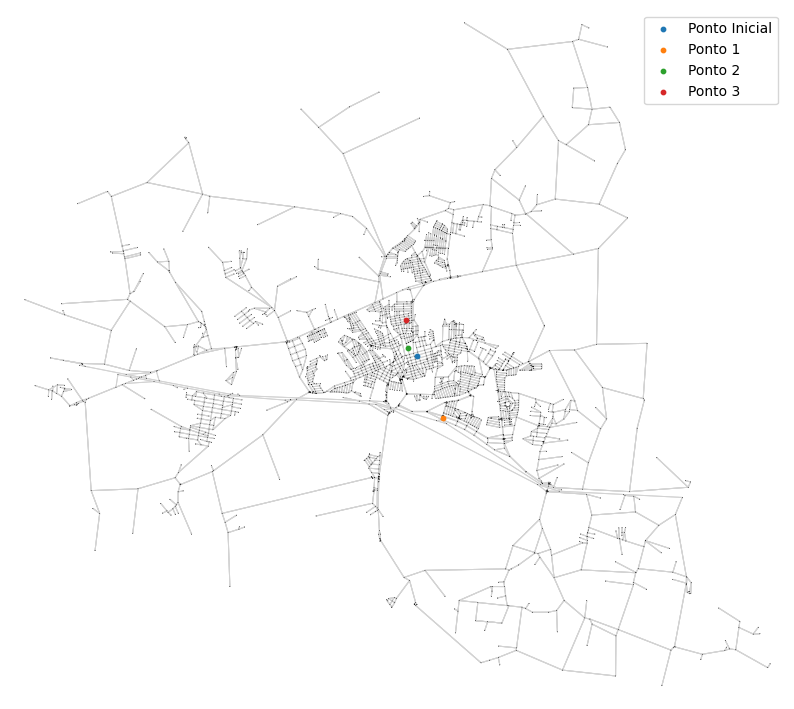

In [23]:
_points = list([initialPoint, *target_points])
plotGrahp(points=_points)


# Implementação do algoritmo de força bruta

In [24]:
def brute_force_shortest_path(initialpoint: Node, points: List[Node]) -> Tuple[List[Node], float, list[str]]:
    min_distance = float('inf')
    best_path = None
    best_street_sequence = []
    pointer = 0

    for perm in permutations(points):
        path = [initialpoint, *perm, initialpoint]
        total_distance = 0
        pointer += 1
        street_sequence = []

        for i in range(len(path) - 1):
            segment = shortPathByPOI(path[i]['osmid'], path[i + 1]['osmid'])
            display(i, segment)
            if not segment:
                total_distance = float('inf')
                break
            total_distance += segment.get('totalLength', 0)
            street_sequence.extend(segment.get('streetsIds', []))

        if total_distance < min_distance:
            min_distance = total_distance
            best_path = path[:]
            best_street_sequence = street_sequence[:]

    print('Número de interações:', pointer)
    return best_path, min_distance, best_street_sequence

def brute_force_shortest_path_with_matrix(
    initialpoint: Dict,
    points: List[Dict],
    dist_matrix: np.ndarray
) -> Tuple[List[Dict], float]:
    n = len(points) + 1 
    min_distance = float('inf')
    best_path = None
    pointer = 0
    point_indices = list(range(1, n)) 
    for perm in permutations(point_indices):
        path_indices = [0] + list(perm) + [0]
        total_distance = 0
        pointer += 1

        for i in range(len(path_indices) - 1):
            from_idx = path_indices[i]
            to_idx = path_indices[i+1]
            dist = dist_matrix[from_idx][to_idx]
            if dist == 0 and from_idx != to_idx:
                total_distance = float('inf')
                break
            total_distance += dist

        if total_distance < min_distance:
            min_distance = total_distance
            best_path = [initialpoint] + [points[i-1] for i in perm] + [initialpoint]

    print('Número de interações:', pointer)
    return best_path, min_distance

array([[   0.  , 3781.95, 1106.94, 1331.58],
       [3168.62,    0.  , 3236.15, 4164.17],
       [ 850.9 , 3991.4 ,    0.  ,  928.02],
       [1251.77, 4286.63, 1455.76,    0.  ]])

Número de interações: 6
Menor caminho:  ['Ponto Inicial', 'Ponto 1', 'Ponto 2', 'Ponto 3', 'Ponto Inicial']
Menor distância (m):  9197.890000000001
Tempo de execução: 0.0002 segundos


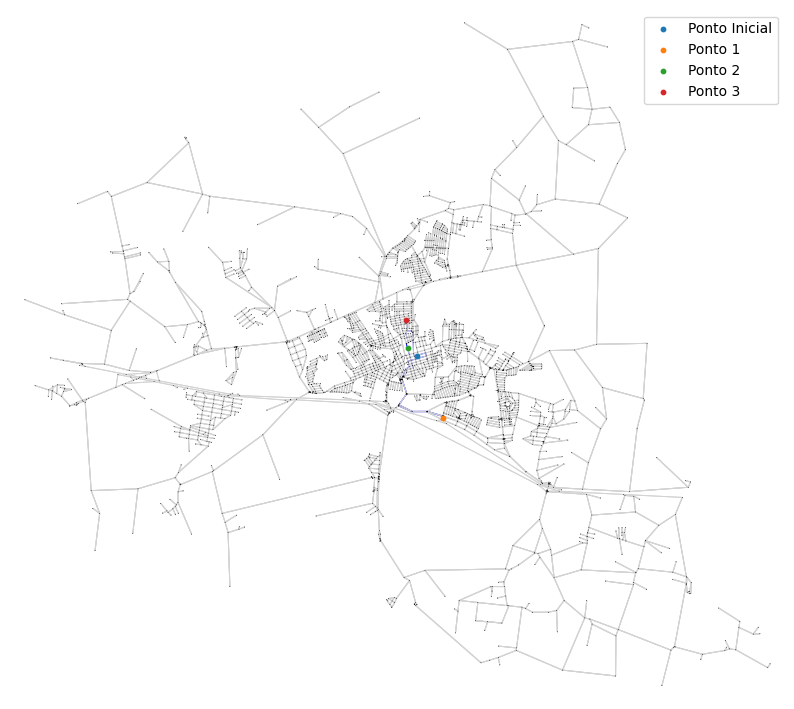

In [ ]:
# gera matriz de distâncias e ruas
dist_matrix, streets_matrix = build_distance_matrix(initialPoint, target_points)
display(dist_matrix)

# resolver TSP com força bruta
start_time = time.perf_counter()  
best_path, best_distance = brute_force_shortest_path_with_matrix(initialPoint, target_points, dist_matrix)
end_time = time.perf_counter() 
# extrair ruas que serão pintadas
colored_streets = extract_streets_from_path(best_path, initialPoint, target_points, streets_matrix)

# gera o grafo com o caminho ótimo e alguma metricas
execution_time = end_time - start_time  
print("Menor caminho: ", list(map(lambda p: p['name'], best_path)))
print("Menor distância (m): ", best_distance)
print(f"Tempo de execução: {execution_time:.4f} segundos")
plotGrahp(points=_points, coloredStreets=colored_streets)

# Implementação do algoritmo Quântico

In [26]:
QiskitRuntimeService.delete_account()


NameError: name 'QiskitRuntimeService' is not defined

In [ ]:
if apiToken:
    QiskitRuntimeService.save_account(channel="ibm_quantum", token=apiToken, overwrite=True, instance='ibm-q/open/main')
    runTimeService = QiskitRuntimeService()    

else:
    print('Informe o token para conectar a ibm')


## listagem de servidores/simuladores disponiveis e escolha do mesmo

In [ ]:
for backend in runTimeService.backends():
    print(backend.name, backend.status())

backend = runTimeService.backend(name='ibm_brisbane')

ibm_sherbrooke <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x000001D156A57D40>
ibm_brisbane <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x000001D156A6C410>


## tratando o input do algoritmo quântico

In [ ]:
all_points = [initialPoint, *target_points, initialPoint] 

dist_matrix, streets_matrix = build_distance_matrix(initialPoint, target_points)
display(dist_matrix)

array([[   0.  , 3781.95, 1106.94, 1331.58],
       [3168.62,    0.  , 3236.15, 4164.17],
       [ 850.9 , 3991.4 ,    0.  ,  928.02],
       [1251.77, 4286.63, 1455.76,    0.  ]])

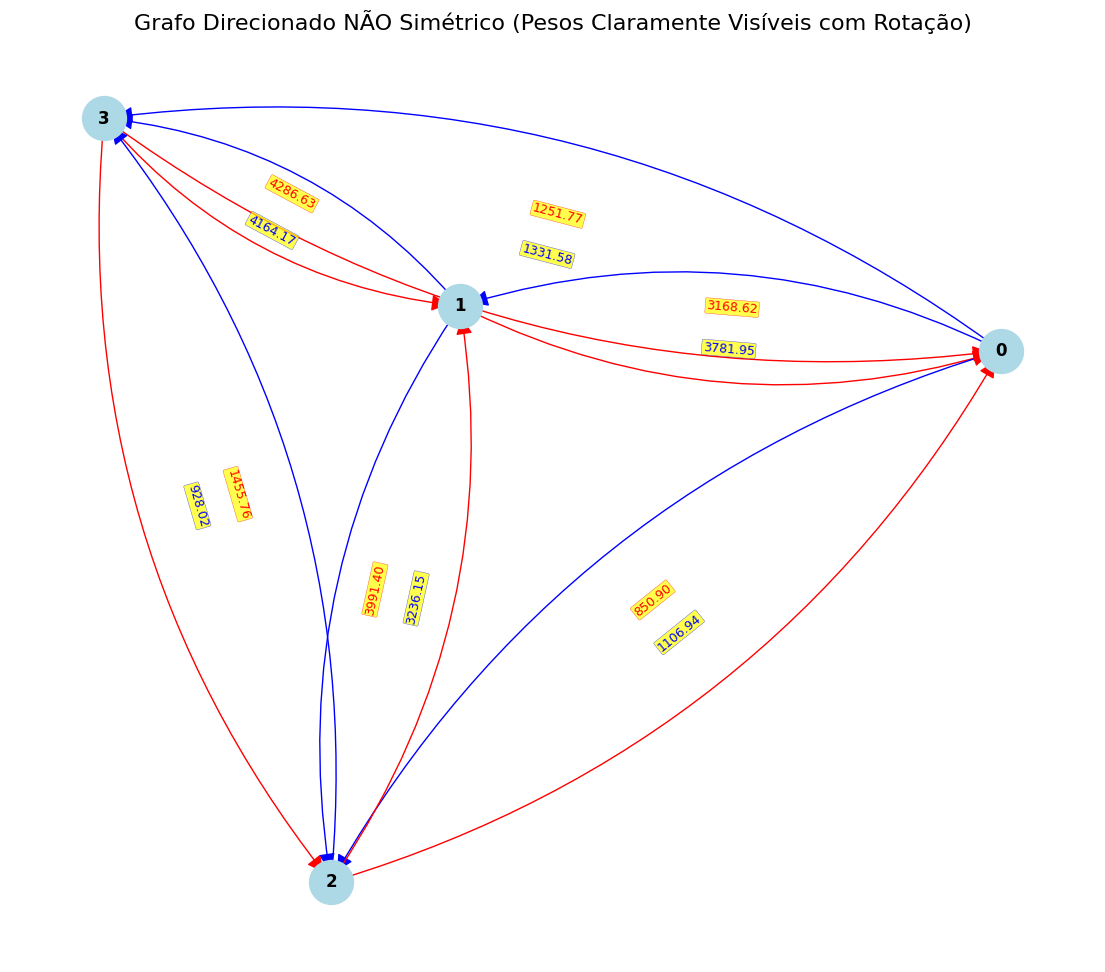

In [ ]:
np.random.seed(13)

# Cria o grafo direcionado
G = nx.DiGraph()

# Adiciona arestas com pesos
n = dist_matrix.shape[0]
for i in range(n):
    for j in range(n):
        if i != j: # Exclui auto-loops
            G.add_edge(i, j, weight=dist_matrix[i][j])

# Layout dos nós
pos = nx.spring_layout(G, seed=13)

plt.figure(figsize=(14, 12)) # Increase figure size for more space

# Desenha os nós
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000) # Increase node size
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold') # Increase node label font size

# Rótulos das arestas (pesos)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {edge: f"{weight:.2f}" for edge, weight in edge_labels.items()}

# Parameters for curvatures and label offsets
rad = 0.2 # Radius of edge curvature
# Reduced offset for better visual attachment
label_offset_distance = 0.04 # Perpendicular offset distance for labels

# Set to keep track of reciprocal pairs already drawn to avoid duplicate drawing
drawn_reciprocal_pairs = set()

# Draw edges and position labels
for u, v in G.edges():
    # Check if a reciprocal edge exists
    has_reciprocal = G.has_edge(v, u)

    x1, y1 = pos[u]
    x2, y2 = pos[v]

    if has_reciprocal and (u, v) not in drawn_reciprocal_pairs: # Only draw reciprocal pairs once
        # Add both directions to the set to avoid re-processing
        drawn_reciprocal_pairs.add((u, v))
        drawn_reciprocal_pairs.add((v, u))

        # Calculate midpoint of the straight line segment between nodes u and v
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2

        # Calculate the vector from u to v
        vec_x, vec_y = x2 - x1, y2 - y1
        dist_uv = np.sqrt(vec_x**2 + vec_y**2)
        if dist_uv == 0: continue # Avoid division by zero for self-loops (though excluded by if i != j)

        # Normalize the vector
        norm_vec_x, norm_vec_y = vec_x / dist_uv, vec_y / dist_uv

        # Perpendicular vector (rotated 90 degrees clockwise)
        perp_x, perp_y = -norm_vec_y, norm_vec_x

        # Calculate angle for rotation (in degrees)
        angle_deg = np.degrees(np.arctan2(vec_y, vec_x))
        # Adjust angle for better readability (e.g., if text is upside down)
        if angle_deg > 90 or angle_deg < -90:
            angle_deg += 180

        # Draw edge u -> v (blue) with curvature
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], arrowsize=25,
                               connectionstyle=f'arc3,rad={rad}', edge_color='blue', arrows=True)
        # Position label for u -> v: offset slightly along the perpendicular vector
        # Apply a smaller offset and use rotation
        label_pos_u_v_x = mid_x + perp_x * label_offset_distance
        label_pos_u_v_y = mid_y + perp_y * label_offset_distance
        plt.text(label_pos_u_v_x, label_pos_u_v_y, edge_labels[(u, v)], # Corrected
                 color='blue', fontsize=9, ha='center', va='center', rotation=angle_deg,
                 bbox=dict(boxstyle="round,pad=0.1", fc="yellow", ec="blue", lw=0.3, alpha=0.7)) # Smaller padding, thinner line

        # Draw edge v -> u (red) with curvature
        nx.draw_networkx_edges(G, pos, edgelist=[(v, u)], arrowsize=25,
                               connectionstyle=f'arc3,rad={rad}', edge_color='red', arrows=True)
        # Position label for v -> u: offset in the opposite perpendicular direction
        label_pos_v_u_x = mid_x - perp_x * label_offset_distance
        label_pos_v_u_y = mid_y - perp_y * label_offset_distance
        plt.text(label_pos_v_u_x, label_pos_v_u_y, edge_labels[(v, u)], # Corrected
                 color='red', fontsize=9, ha='center', va='center', rotation=angle_deg,
                 bbox=dict(boxstyle="round,pad=0.1", fc="yellow", ec="red", lw=0.3, alpha=0.7)) # Smaller padding, thinner line

    elif not has_reciprocal: # One-way edges (straight, gray)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], arrowsize=25,
                               edge_color='gray', arrows=True)
        # Ponto médio para arestas retas
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        # Calculate angle for rotation
        vec_x, vec_y = x2 - x1, y2 - y1
        angle_deg = np.degrees(np.arctan2(vec_y, vec_x))
        if angle_deg > 90 or angle_deg < -90:
            angle_deg += 180

        plt.text(mid_x, mid_y, edge_labels[(u, v)],
                 color='gray', fontsize=9, ha='center', va='center', rotation=angle_deg,
                 bbox=dict(boxstyle="round,pad=0.1", fc="lightgray", ec="gray", lw=0.3, alpha=0.7))

plt.title("Grafo Direcionado NÃO Simétrico (Pesos Claramente Visíveis com Rotação)", fontsize=16)
plt.axis('off') # Desliga os eixos
plt.show()


In [ ]:
from qiskit_optimization import QuadraticProgram

def build_asymmetric_tsp_qubo(distance_matrix):
    num_cities = len(distance_matrix)
    problem = QuadraticProgram()
    
    for i in range(num_cities):
        for j in range(num_cities):
            problem.binary_var(name=f"x_{i}_{j}")
    
    # Restrição 1: cada cidade deve aparecer exatamente uma vez
    for i in range(num_cities):
        problem.linear_constraint(
            linear={f"x_{i}_{j}": 1 for j in range(num_cities)},
            sense='==',
            rhs=1,
            name=f"city_{i}_once"
        )
    
    # Restrição 2: cada posição na rota deve ser ocupada por apenas uma cidade
    for j in range(num_cities):
        problem.linear_constraint(
            linear={f"x_{i}_{j}": 1 for i in range(num_cities)},
            sense='==',
            rhs=1,
            name=f"pos_{j}_once"
        )
    
    
    # Função objetivo: somar distâncias entre cidades consecutivas
    objective = {}
    for i in range(num_cities):
        for j in range(num_cities):
            for k in range(num_cities):
                if i != j:
                    next_k = (k + 1) % num_cities
                    objective[(f"x_{i}_{k}", f"x_{j}_{next_k}")] = distance_matrix[i][j]
    
    problem.minimize(quadratic=objective)

    return problem

In [ ]:
problem = build_asymmetric_tsp_qubo(dist_matrix)

qubo = QuadraticProgramToQubo().convert(problem)


In [ ]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 1921018.849999998
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 

In [ ]:

# from qiskit_ibm_runtime import Sampler

from qiskit.primitives import Sampler
# from qiskit.primitives import Sampler

# samplerRemoto = Sampler(mode=backend)

samplerRemoto = Sampler()


qaoa = QAOA(sampler=samplerRemoto, reps=1, optimizer=SPSA(maxiter=300))

resultQAOA = qaoa.compute_minimum_eigenvalue(operator=qubitOp)

qaoa_objective_value = resultQAOA.eigenvalue.real + offset



C:\Users\marco\AppData\Local\Temp\ipykernel_29224\3346065702.py:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  samplerRemoto = Sampler()


In [ ]:

def decode_solution(result, num_cities):
    route = [None] * num_cities
    for var, value in result.variables_dict.items():
        if value > 0.5:
            _, i, j = var.split('_')
            route[int(j)] = int(i)
    return route

route = decode_solution(resultQAOA, len(dist_matrix))
print("Melhor rota encontrada:", route)

Melhor rota encontrada: [3, 0, 1, 2]


In [ ]:
# qp2qubo = QuadraticProgramToQubo()
# qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 1950676.399999999
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 

In [ ]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 9197.889999999898
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


## Verificando se o circulo Hamiltoniano do problema foi feito com sucesso

In [ ]:
# def draw_tsp_solution(G, order, pos):
#     G2 = nx.DiGraph()
#     G2.add_nodes_from(G)
#     n = len(order)
#     for i in range(n):
#         j = (i + 1) % n
#         G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
#     default_axes = plt.axes(frameon=True)
#     nx.draw_networkx(
#         G2, node_color='red', edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
#     )
#     edge_labels = nx.get_edge_attributes(G2, "weight")
#     nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


energy: -1940914.4899999995
tsp objective: 9761.90999999945
feasible: True
solution: [3, 1, 0, 2]
solution objective: 9490.210000000001


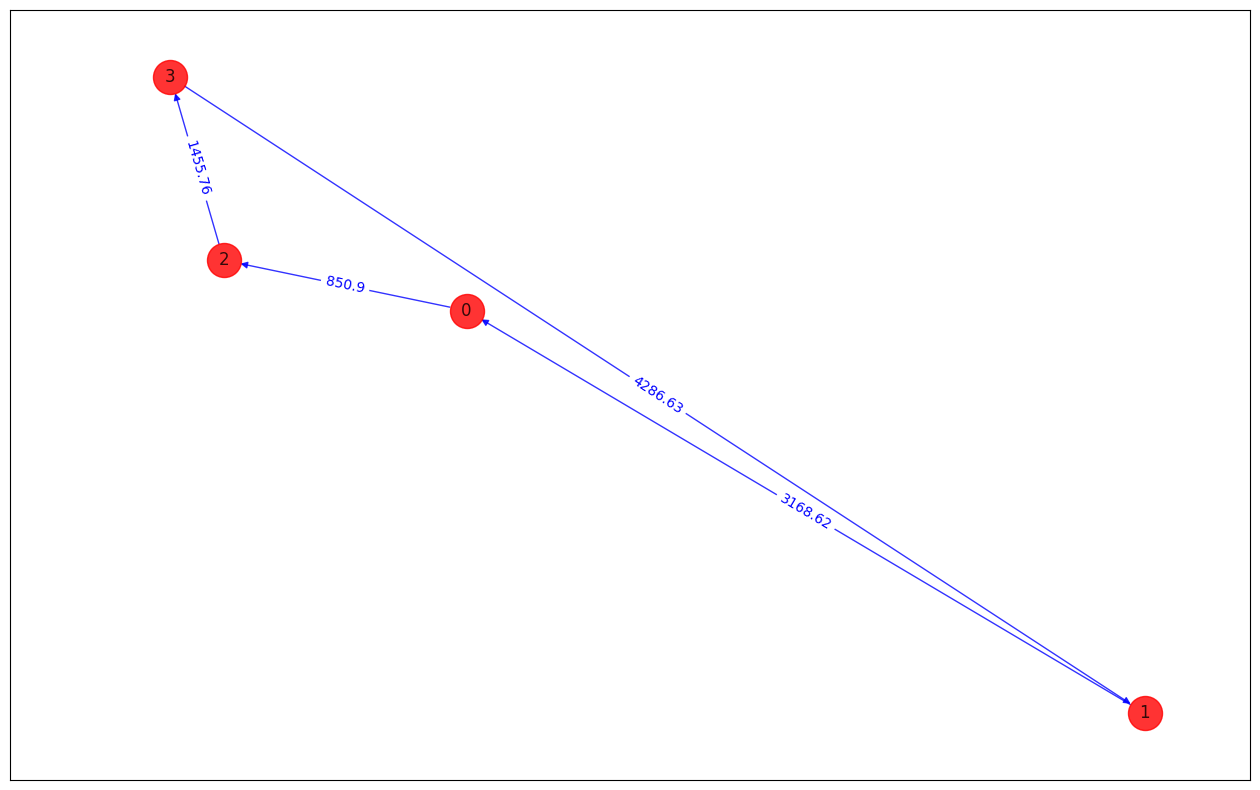

In [ ]:
# plt.figure(figsize=(16,10))

# ee = NumPyMinimumEigensolver()

# result = ee.compute_minimum_eigenvalue(qubitOp)


# print("energy:", result.eigenvalue.real)
# print("tsp objective:", result.eigenvalue.real + offset)

# x = tsp.sample_most_likely(result.eigenstate)

# print("feasible:", qubo.is_feasible(x))
# z = tsp.interpret(x)
# print("solution:", z)
# print("solution objective:", tsp.tsp_value(z, dist_matrix))
# #
# pos = {i: (p['longitude'], p['latitude']) for i, p in enumerate(all_points)}
# draw_tsp_solution(tsp.graph, z, pos)


In [ ]:


algorithm_globals.random_seed = 123
seed = 10598
optimizer = SPSA(maxiter=300)

In [ ]:
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")

# transpiled_ansatz = transpile(ry, backend)
transpiled_ansatz = ry


# novoqtdQubitOp = qubitOp.apply_layout(transpiled_ansatz.layout)
novoqtdQubitOp = qubitOp


In [ ]:
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import Sampler as SamplerRemoto
##aqui tive que jogar para esse Sampler para rodar local
### para rodar em nuvem tem que pegar o samplerRemoto ai
samplerRemoto = SamplerRemoto(mode=backend)
##e passar para o samplingVqe essa sampler de cima porem vai dar erro na funcao compute_minimum_eigenvalue
qtdQubits = transpiled_ansatz.num_qubits

vqe = SamplingVQE(sampler=Sampler(), ansatz=transpiled_ansatz, optimizer=optimizer)

print(vqe.ansatz)


C:\Users\marco\AppData\Local\Temp\ipykernel_26732\3203423666.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=transpiled_ansatz, optimizer=optimizer)


      »
 q_0: »
      »
 q_1: »
      »
 q_2: »
      »
 q_3: »
      »
 q_4: »
      »
 q_5: »
      »
 q_6: »
      »
 q_7: »
      »
 q_8: »
      »
 q_9: »
      »
q_10: »
      »
q_11: »
      »
q_12: »
      »
q_13: »
      »
q_14: »
      »
q_15: »
      »
«      ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
« q_0: ┤0                                                                                                                                          

In [ ]:

# result = vqe.compute_minimum_eigenvalue(novoqtdQubitOp)


In [ ]:
# plt.figure(figsize=(16,10))
# print("energy:", result.eigenvalue.real)
# print("time:", result.optimizer_time)
# x = tsp.sample_most_likely(result.eigenstate)
# print("feasible:", qubo.is_feasible(x))
# z = tsp.interpret(x)
# print("solution:", z)
# print("solution objective:", tsp.tsp_value(z, dist_matrix))
# draw_tsp_solution(tsp.graph, z, pos)

energy: -1940914.4899999995


AttributeError: 'NumPyMinimumEigensolverResult' object has no attribute 'optimizer_time'

<Figure size 1600x1000 with 0 Axes>

In [ ]:
result

objective function value: 9761.91
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0, x_2_3=0.0, x_3_0=0.0, x_3_1=1.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS
solution: [0, 3, 2, 1]
solution objective: 9947.36


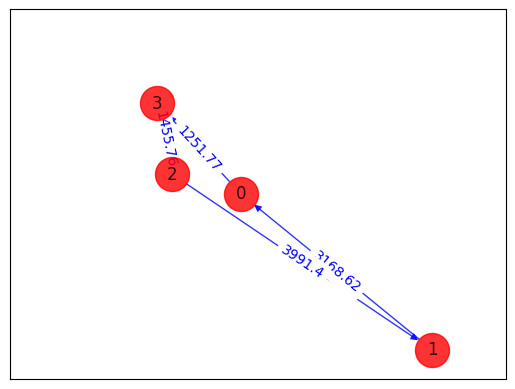

In [ ]:
# algorithm_globals.random_seed = 123
# seed = 10598

# # create minimum eigen optimizer based on SamplingVQE
# vqe_optimizer = MinimumEigenOptimizer(vqe)

# # solve quadratic program
# result2 = vqe_optimizer.solve(qp)
# print(result2.prettyprint())

# z = tsp.interpret(x)
# print("solution:", z)
# print("solution objective:", tsp.tsp_value(z, dist_matrix))


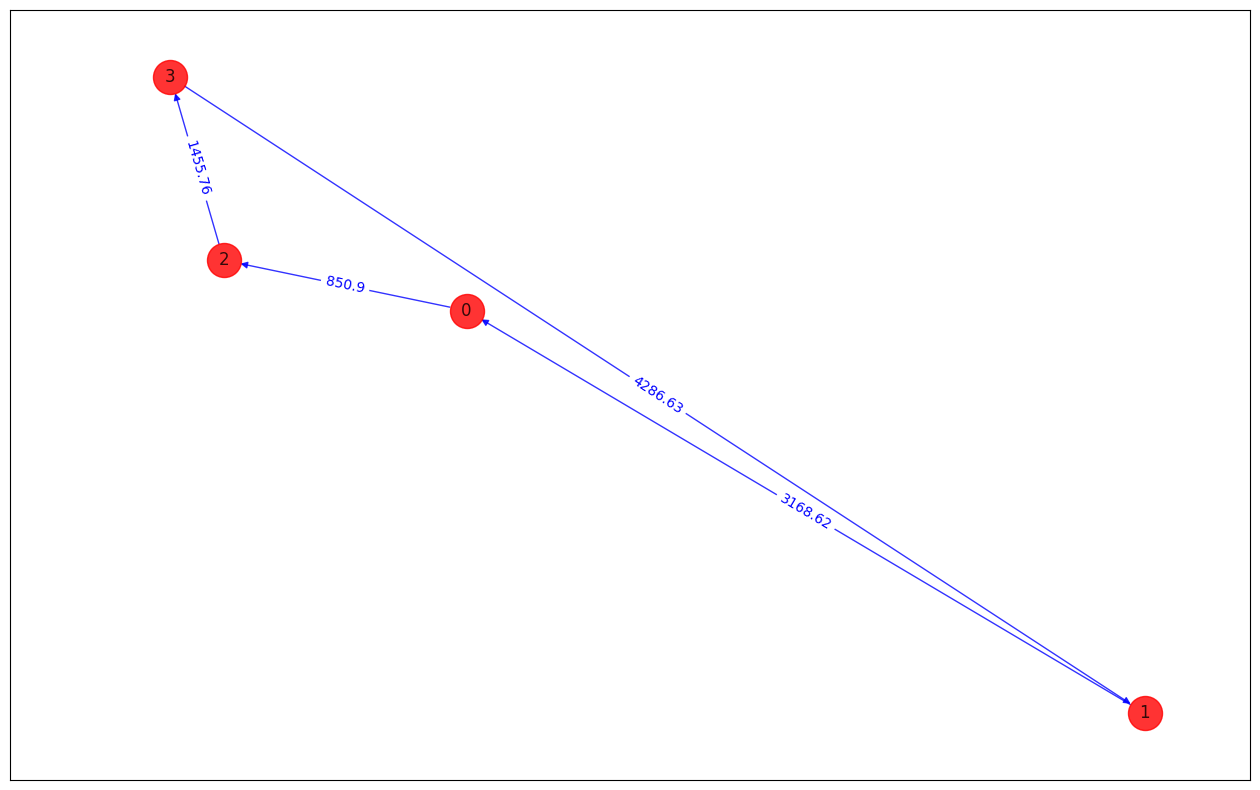

In [ ]:
# plt.figure(figsize=(16,10))
# draw_tsp_solution(tsp.graph, z, pos)